#Import Libraries

In [3]:
!pip install rdkit

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)


Mounted at /content/gdrive/


In [5]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmilesFromSmiles
from scipy import stats
from scipy.stats import normaltest,shapiro,ks_1samp,mannwhitneyu
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler,StandardScaler, QuantileTransformer, StandardScaler, Normalizer
from sklearn.decomposition import PCA


#Import Dataset

In [6]:
df_raw = pd.read_csv("gdrive/MyDrive/PROJECT/KOMPUTASI/v2-Regression Anti Inflammatory/cleaned_dataset.csv", sep=";")[["Chembl ID","Smiles","IC50","pIC50","category"]]

In [7]:
df=df_raw.copy()

In [8]:
df.head()

,Chembl ID,Smiles,IC50,pIC50,category
0,CHEMBL571,CC(C(=O)O)c1cccc(C(=O)c2ccccc2)c1,690.00,-2.838849,active
1,CHEMBL126345,CS(=O)(=O)c1ccc(-c2[nH]c(SC#N)cc2-c2ccc(F)cc2)cc1,72000.00,-4.857332,intermediate
2,CHEMBL98193,CN1CC(c2ccc(S(C)(=O)=O)cc2)=C(c2ccccc2)O1,5380.00,-3.730782,intermediate
3,CHEMBL42180,Cc1ccc(-c2nc(C(F)(F)F)cn2-c2ccc(S(C)(=O)=O)cc2...,109.65,-2.040009,active
4,CHEMBL255175,NS(=O)(=O)c1ccc(/N=C/c2ccc([N+](=O)[O-])cc2)cc1,3000.00,-3.477121,intermediate


#Change Category

"inactive" and "intermediate" **merged**


"active" and "potent" **merged**

In [9]:
category=[]
for x in df["pIC50"]:
  if x <=-3.2:
    category.append("inactive")
  else:
    category.append("active")

df["category"]=category


In [10]:
df

,Chembl ID,Smiles,IC50,pIC50,category
0,CHEMBL571,CC(C(=O)O)c1cccc(C(=O)c2ccccc2)c1,690.00,-2.838849,active
1,CHEMBL126345,CS(=O)(=O)c1ccc(-c2[nH]c(SC#N)cc2-c2ccc(F)cc2)cc1,72000.00,-4.857332,inactive
2,CHEMBL98193,CN1CC(c2ccc(S(C)(=O)=O)cc2)=C(c2ccccc2)O1,5380.00,-3.730782,inactive
3,CHEMBL42180,Cc1ccc(-c2nc(C(F)(F)F)cn2-c2ccc(S(C)(=O)=O)cc2...,109.65,-2.040009,active
4,CHEMBL255175,NS(=O)(=O)c1ccc(/N=C/c2ccc([N+](=O)[O-])cc2)cc1,3000.00,-3.477121,inactive
...,...,...,...,...,...
2853,CHEMBL298031,COc1ccc(-n2nc(C(F)(F)F)cc2-c2ccc(NS(C)(=O)=O)c...,960.00,-2.982271,active
2854,CHEMBL93372,CC(=O)Oc1ccc(C2=C(c3ccc(S(C)(=O)=O)cc3)COC2=O)cc1,1.26,-0.100371,active
2855,CHEMBL1939671,Cc1c(CC(=O)OCCCO[N+](=O)[O-])cc(-c2ccc(S(C)(=O...,7.00,-0.845098,active
2856,CHEMBL4641524,Fc1ccccc1-c1nnc(Cn2c(CN3CCCCC3)nc3ccccc32)o1,60.00,-1.778151,active


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2858 entries, 0 to 2857
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Chembl ID  2858 non-null   object 
 1   Smiles     2858 non-null   object 
 2   IC50       2858 non-null   float64
 3   pIC50      2858 non-null   float64
 4   category   2858 non-null   object 
dtypes: float64(2), object(3)
memory usage: 111.8+ KB


In [12]:
df.describe(include="all")

,Chembl ID,Smiles,IC50,pIC50,category
count,2858,2858,2.858000e+03,2858.000000,2858
unique,2858,2858,NaN,NaN,2
top,CHEMBL571,CC(C(=O)O)c1cccc(C(=O)c2ccccc2)c1,NaN,NaN,active
freq,1,1,NaN,NaN,1595
mean,NaN,NaN,7.187657e+05,-2.964198,NaN
std,NaN,NaN,1.413837e+07,1.267338,NaN
min,NaN,NaN,5.998000e-03,-8.619790,NaN
25%,NaN,NaN,1.200000e+02,-3.837114,NaN
50%,NaN,NaN,9.700000e+02,-2.986772,NaN
75%,NaN,NaN,6.872500e+03,-2.079181,NaN


#RdKit Descriptors

In [13]:
descriptors_df = pd.read_csv("gdrive/MyDrive/PROJECT/KOMPUTASI/v2-Regression Anti Inflammatory/rdkit_descriptor.csv",sep=";")

In [14]:
descriptors_df = descriptors_df[["MolWt","TPSA","NumHAcceptors","NumHDonors","NumRotatableBonds","MolLogP"]].copy()

In [15]:
descriptors_df

,MolWt,TPSA,NumHAcceptors,NumHDonors,NumRotatableBonds,MolLogP
0,254.285,54.37,2,1,4,3.10570
1,372.446,73.72,4,1,4,4.46448
2,315.394,46.61,4,0,3,2.83540
3,398.381,51.96,4,0,3,4.40912
4,305.315,115.66,5,1,4,1.99280
...,...,...,...,...,...,...
2853,411.405,73.22,5,1,5,3.93820
2854,372.398,86.74,6,0,4,2.48300
2855,490.509,117.74,8,0,10,3.67942
2856,391.450,59.98,6,0,5,4.25960


#Final EDA Dataframe

In [16]:
descriptors_df = pd.concat([df["category"],descriptors_df],axis=1)

In [17]:
combined_df = pd.concat([df.drop(columns="category"),descriptors_df],axis=1)
combined_df.head()

,Chembl ID,Smiles,IC50,pIC50,category,MolWt,TPSA,NumHAcceptors,NumHDonors,NumRotatableBonds,MolLogP
0,CHEMBL571,CC(C(=O)O)c1cccc(C(=O)c2ccccc2)c1,690.00,-2.838849,active,254.285,54.37,2,1,4,3.10570
1,CHEMBL126345,CS(=O)(=O)c1ccc(-c2[nH]c(SC#N)cc2-c2ccc(F)cc2)cc1,72000.00,-4.857332,inactive,372.446,73.72,4,1,4,4.46448
2,CHEMBL98193,CN1CC(c2ccc(S(C)(=O)=O)cc2)=C(c2ccccc2)O1,5380.00,-3.730782,inactive,315.394,46.61,4,0,3,2.83540
3,CHEMBL42180,Cc1ccc(-c2nc(C(F)(F)F)cn2-c2ccc(S(C)(=O)=O)cc2...,109.65,-2.040009,active,398.381,51.96,4,0,3,4.40912
4,CHEMBL255175,NS(=O)(=O)c1ccc(/N=C/c2ccc([N+](=O)[O-])cc2)cc1,3000.00,-3.477121,inactive,305.315,115.66,5,1,4,1.99280


#Descriptive Analysis

##Defining function

In [18]:
#create a method for descriptive statistic

def describe_all(df):
  data = {}

  for col in df.columns:
    min = df[col].min()
    max = df[col].max()
    mean = df[col].mean()
    median = df[col].median()
    std = df[col].std()
    skew = df[col].skew()
    kurt = df[col].kurt()
    data[col]={
        "min":min,
        "max":max,
        "median":median,
        "mean":mean,
        "std":std,
        "skew":skew,
        "kurt":kurt,
    }
  return data

def d_analysis(dicti):
  data ={}
  for x,y in dicti.items():
    result = describe_all(y)
    data[x]=result

  return data


#Descriptive DataFrame

In [19]:
phys = combined_df[["category","MolWt","TPSA","NumHAcceptors","NumHDonors","NumRotatableBonds","MolLogP"]].copy()

In [20]:
active = phys[phys['category']=="active"].drop(columns=["category"])
inactive = phys[phys['category']=="inactive"].drop(columns=["category"])

In [21]:
dts = {
    "active":active,
    "inactive":inactive,
}

In [22]:
descriptive_df = d_analysis(dts)

In [23]:
groups = ["inactive","active"]
cheminf = ["MolWt","TPSA","NumHAcceptors","NumHDonors","NumRotatableBonds","MolLogP"]

In [24]:
desc_active=pd.DataFrame(descriptive_df["active"])
desc_inactive=pd.DataFrame(descriptive_df["inactive"])

In [25]:
desc_active["category"]="active"
desc_inactive["category"]="inactive"

In [26]:
pd.concat([desc_active,desc_inactive]).pivot(columns="category")

MolWt                    TPSA             NumHAcceptors  \
category      active    inactive      active    inactive        active   
kurt        0.305817    0.002198    0.715926   -0.034289     -0.163744   
max       499.995000  498.605000  159.930000  171.640000      9.000000   
mean      375.866658  355.150161   72.844878   74.585186      4.639498   
median    377.868000  358.302000   71.090000   71.310000      5.000000   
min       108.144000  126.111000   12.030000    3.240000      1.000000   
skew       -0.386444   -0.265133    0.566687    0.325610      0.200101   
std        55.735066   65.140531   22.657003   25.590945      1.608422   

                   NumHDonors           NumRotatableBonds             \
category  inactive     active  inactive            active   inactive   
kurt      0.053378   0.408626  0.522357          2.742627   1.317182   
max       9.000000   4.000000  4.000000         13.000000  11.000000   
mean      4.649248   0.857680  1.060174          4.129154   4.178147   
median    5.000000   1.000000  1.000000          4.000000   4.000000   
min       1.000000   0.000000  0.000000          0.000000   0.000000   
skew      0.339389   0.715230  0.929732          1.279151   0.915365   
std       1.552468   0.785172  1.015501          1.707500   1.793393   

           MolLogP            
category    active  inactive  
kurt      3.958822  2.131396  
max       4.992520  4.998300  
mean      3.632183  3.219793  
median    3.784700  3.403800  
min      -2.765300 -4.509800  
skew     -1.433984 -1.032919  
std       0.930387  1.177470

#Univariate Analysis

##The Active And Inactive Compounds

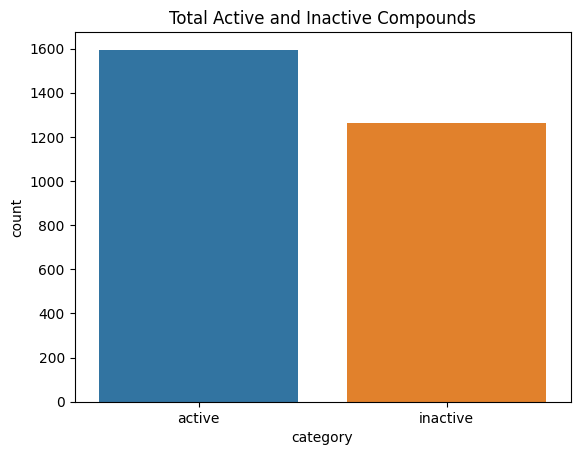

In [27]:
fig = sns.countplot(x='category', data=combined_df)
plt.title("Total Active and Inactive Compounds")
plt.show()

##Distribution of Physicochemicals

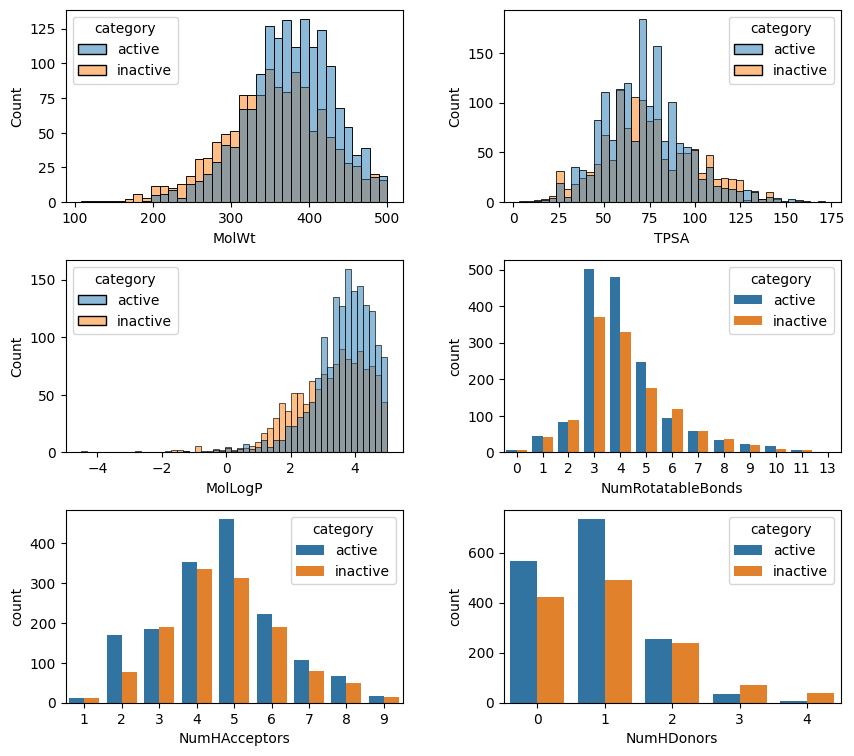

In [28]:
fig,axes = plt.subplots(
    ncols=2,
    nrows=3,
    figsize=(10,9),
    # layout="constrained"
)

axes[0,0]=sns.histplot(
    data=combined_df,
    x="MolWt",
    hue="category",
    ax=axes[0,0]
    # log_scale=True,
)
axes[0,1]=sns.histplot(
    data=combined_df,
    x="TPSA",
    hue="category",
    ax=axes[0,1]
    # log_scale=True,
)
axes[1,0]=sns.histplot(
    data=combined_df,
    x="MolLogP",
    hue="category",
    ax=axes[1,0],
    # log_scale=True,
)

axes[1,1]=sns.countplot(
    data=combined_df,
    x="NumRotatableBonds",
    hue="category",
    ax=axes[1,1]
    # log_scale=True,
)

axes[2,0]=sns.countplot(
    data=combined_df,
    x="NumHAcceptors",
    hue="category",
    ax=axes[2,0]
    # log_scale=True,
)
axes[2,0]=sns.countplot(
    data=combined_df,
    x="NumHDonors",
    hue="category",
    ax=axes[2,1]
    # log_scale=True,
)
plt.subplots_adjust( hspace=0.3,wspace=0.3)
fig.show()

<Axes: xlabel='TPSA', ylabel='Count'>

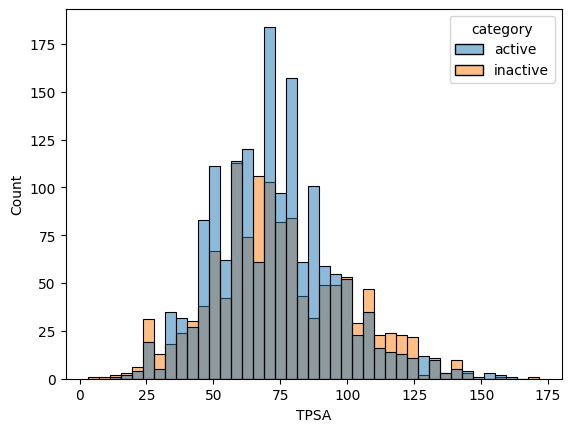

In [29]:
sns.histplot(
    data=combined_df,
    x="TPSA",
    hue="category",
    # ax=axes[0,1]
    # log_scale=True,
)


###Box Plot

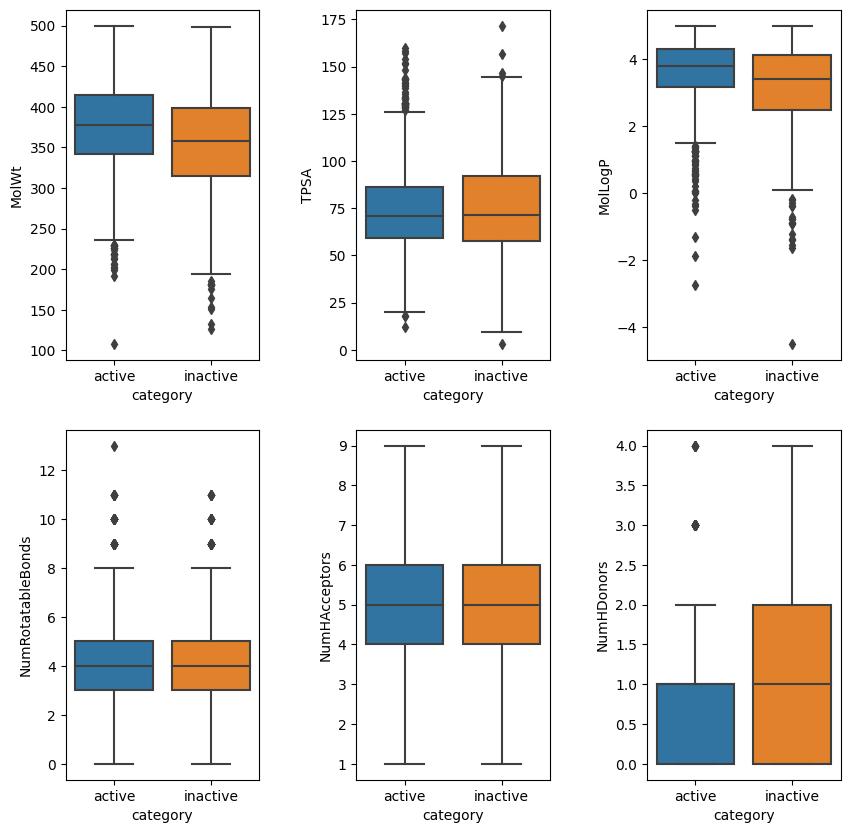

In [30]:
fig,axes = plt.subplots(
    ncols=3,
    nrows=2,
    figsize=(10,10),
    # layout="constrained"
)

axes[0,0]=sns.boxplot(
    data=combined_df,
    y="MolWt",
    x="category",
    ax=axes[0,0]
    # log_scale=True,
)
axes[0,1]=sns.boxplot(
    data=combined_df,
    y="TPSA",
    x="category",
    ax=axes[0,1]
    # log_scale=True,
)
axes[0,2]=sns.boxplot(
    data=combined_df,
    y="MolLogP",
    x="category",
    ax=axes[0,2],
    # log_scale=True,
)

axes[1,0]=sns.boxplot(
    data=combined_df,
    y="NumRotatableBonds",
    x="category",
    ax=axes[1,0]
    # log_scale=True,
)

axes[1,1]=sns.boxplot(
    data=combined_df,
    y="NumHAcceptors",
    x="category",
    ax=axes[1,1]
    # log_scale=True,
)
axes[1,2]=sns.boxplot(
    data=combined_df,
    y="NumHDonors",
    x="category",
    ax=axes[1,2]
    # log_scale=True,
)

plt.subplots_adjust( hspace=0.2,wspace=0.5)
fig.show()

#Correlation Analysis

<ipython-input-31-dcf6146abd7d>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(combined_df.corr(),annot=True)


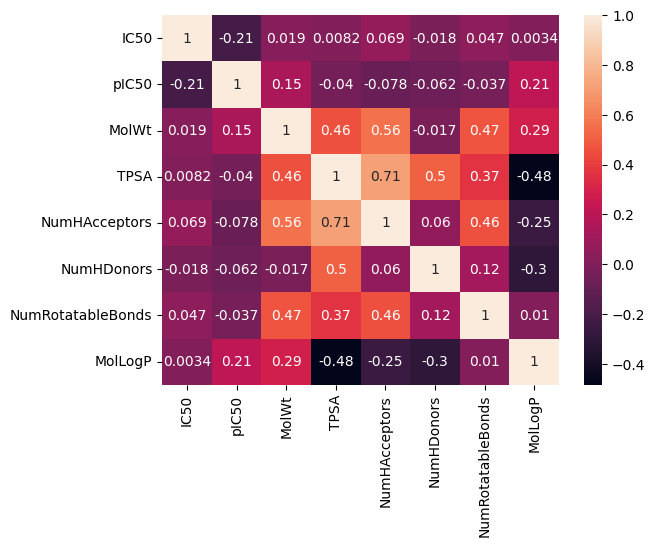

In [31]:
# Should or shouldn't
sns.heatmap(combined_df.corr(),annot=True)
plt.show()


#Comparison Analysis

In [32]:
cheminf=["MolWt","TPSA","NumHAcceptors","NumHDonors","NumRotatableBonds","MolLogP"]

##Normalization Test

In [33]:
for x in cheminf:
  a = ks_1samp(descriptors_df[descriptors_df["category"]=="active"][x],stats.norm.cdf).pvalue
  b = ks_1samp(descriptors_df[descriptors_df["category"]=="inactive"][x],stats.norm.cdf).pvalue
  print(f"{x} p-value\nactive: {a}\ninactive: {b}")
  print(f"Next Analysis:","t-Test" if a > 0.05 and b > 0.05 else "Mann-Whitney U Test","\n")


MolWt p-value
active: 0.0
inactive: 0.0
Next Analysis: Mann-Whitney U Test 

TPSA p-value
active: 0.0
inactive: 0.0
Next Analysis: Mann-Whitney U Test 

NumHAcceptors p-value
active: 0.0
inactive: 0.0
Next Analysis: Mann-Whitney U Test 

NumHDonors p-value
active: 0.0
inactive: 1.333665434049308e-299
Next Analysis: Mann-Whitney U Test 

NumRotatableBonds p-value
active: 0.0
inactive: 0.0
Next Analysis: Mann-Whitney U Test 

MolLogP p-value
active: 0.0
inactive: 0.0
Next Analysis: Mann-Whitney U Test 



##Mann-Whitney U Test

In [34]:
# u_test_r =
for x in cheminf:
  a=descriptors_df[descriptors_df["category"]=="active"][x]
  b=descriptors_df[descriptors_df["category"]=="inactive"][x]
  c=mannwhitneyu(a,b).pvalue
  print(f"{x} p-value: {c}")
  print("There is significant different" if c <0.05 else "There is no significant different","\n")

MolWt p-value: 9.929318804493325e-19
There is significant different 

TPSA p-value: 0.12131440319813429
There is no significant different 

NumHAcceptors p-value: 0.7791462815091413
There is no significant different 

NumHDonors p-value: 2.655173246386387e-05
There is significant different 

NumRotatableBonds p-value: 0.5292417725194376
There is no significant different 

MolLogP p-value: 2.304133748239928e-21
There is significant different 



#Principal Component Analysis

##Standardize

In [35]:
scaler = StandardScaler()

In [36]:
quan_data = combined_df.copy()[["MolWt","TPSA","NumHAcceptors","NumHDonors","NumRotatableBonds","MolLogP"]]

In [37]:
quan_data.head()

,MolWt,TPSA,NumHAcceptors,NumHDonors,NumRotatableBonds,MolLogP
0,254.285,54.37,2,1,4,3.10570
1,372.446,73.72,4,1,4,4.46448
2,315.394,46.61,4,0,3,2.83540
3,398.381,51.96,4,0,3,4.40912
4,305.315,115.66,5,1,4,1.99280


In [38]:
scaled = scaler.fit_transform(quan_data)

In [39]:
scaled

array([[-1.84527248, -0.80166821, -1.66970888,  0.05872945, -0.08639465,
        -0.32284542],
       [ 0.09411813,  0.00441784, -0.4065993 ,  0.05872945, -0.08639465,
         0.95148469],
       [-0.84228316, -1.12493579, -0.4065993 , -1.05285183, -0.65928542,
        -0.57634594],
       ...,
       [ 2.03190026,  1.83821153,  2.11961985, -1.05285183,  3.35094995,
         0.21521716],
       [ 0.40603305, -0.56796574,  0.85651027, -1.05285183,  0.48649611,
         0.75933824],
       [-1.7234379 , -1.01162551, -1.66970888,  1.17031074, -0.65928542,
         0.60048542]])

##PCA Object

In [40]:
num_cumponents = 2

In [41]:
pca = PCA(num_cumponents)
pca

PCA(n_components=2)

In [42]:
pca.fit(scaled)

PCA(n_components=2)

In [43]:
# Get the explained variance
pca.explained_variance_

array([2.67012468, 1.57071596])

In [44]:
# Get the explained variance ratio
pca.explained_variance_ratio_

array([0.44486507, 0.2616944 ])

In [45]:
# Get the principal components
pca.components_

array([[ 0.39815229,  0.55528739,  0.52021974,  0.24893519,  0.39328198,
        -0.21415566],
       [-0.50052119,  0.21442098, -0.11659798,  0.46383557, -0.27856206,
        -0.63021174]])

In [46]:
projected_data = pd.DataFrame(pca.components_.T,columns=["PC1","PC2"])


In [47]:
projected_data["category"] = quan_data.columns
projected_data

,PC1,PC2,category
0,0.398152,-0.500521,MolWt
1,0.555287,0.214421,TPSA
2,0.520220,-0.116598,NumHAcceptors
3,0.248935,0.463836,NumHDonors
4,0.393282,-0.278562,NumRotatableBonds
5,-0.214156,-0.630212,MolLogP


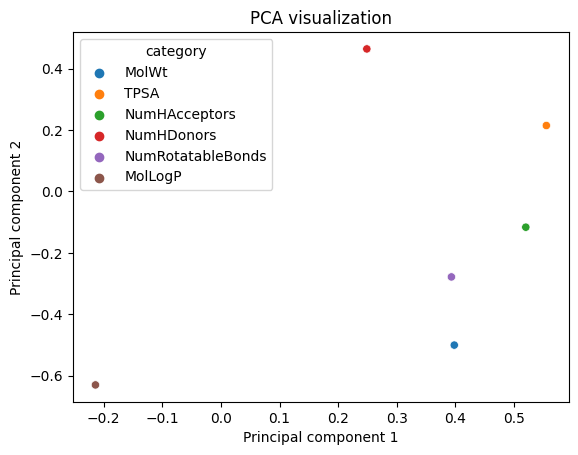

In [48]:
sns.scatterplot(
    x="PC1",y="PC2",
    data=projected_data,
    hue="category"
    )

plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.title('PCA visualization')
plt.show()

In [49]:
# projected_data = pd.concat([projected_data,df_raw["category"]],axis=1)

In [50]:
# Project the data onto the principal components
projected_data = pd.DataFrame(pca.transform(scaled),columns=["PC1","PC2"])

In [51]:
projected_data = pd.concat([projected_data,df_raw["category"]],axis=1)

In [52]:
projected_data

,PC1,PC2,category
0,-1.998690,1.201156,active
1,-0.394718,-0.547082,intermediate
2,-1.569490,0.286301,intermediate
3,-1.219493,-1.277795,active
4,0.961727,1.766263,intermediate
...,...,...,...
2853,0.507866,-0.793770,active
2854,0.684505,0.077886,potent
2855,3.942096,-2.427431,active
2856,0.058474,-1.527293,active


##PCA Visualization

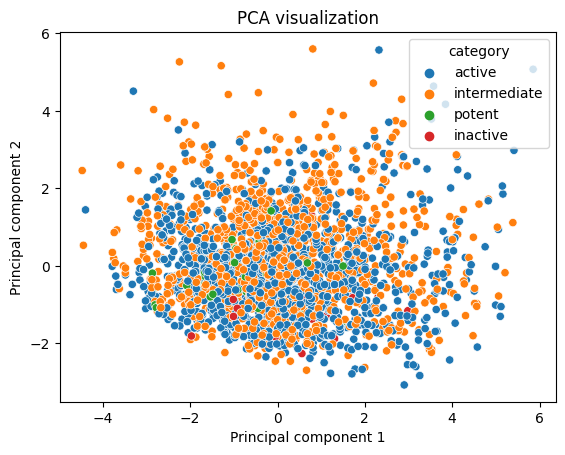

In [53]:
sns.scatterplot(
    x="PC1",y="PC2",
    data=projected_data,
    hue="category"
    )

plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.title('PCA visualization')
plt.show()

In [54]:
# import plotly.express as px

In [55]:
# fig = px.scatter_3d(
#     projected_data,
#     x="PC1",y="PC2",z="PC3",

#     color="category")
# fig.show()

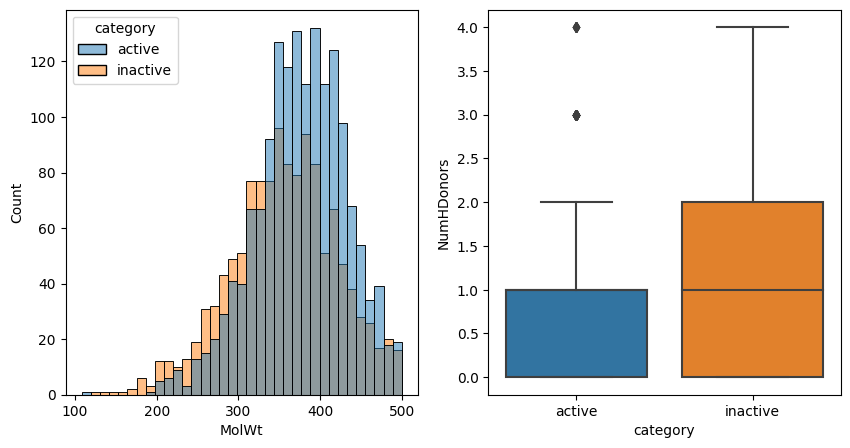

In [56]:
fig,axes = plt.subplots(
    ncols=2,
    nrows=1,
    figsize=(10,5),
    # layout="constrained"
)

axes[0]=sns.histplot(
    data=combined_df,
    x="MolWt",
    hue="category",
    ax=axes[0]
    # log_scale=True,
)

axes[1]=sns.boxplot(
    data=combined_df,
    y="NumHDonors",
    x="category",
    ax=axes[1]
)

# axes[1,0]=sns.scatterplot(
#     x="PC1",y="PC2",
#     data=projected_data,
#     hue="category",
#     ax=axes[1,0]
#     )


# plt.title("Overview")

<Axes: xlabel='MolWt', ylabel='Count'>

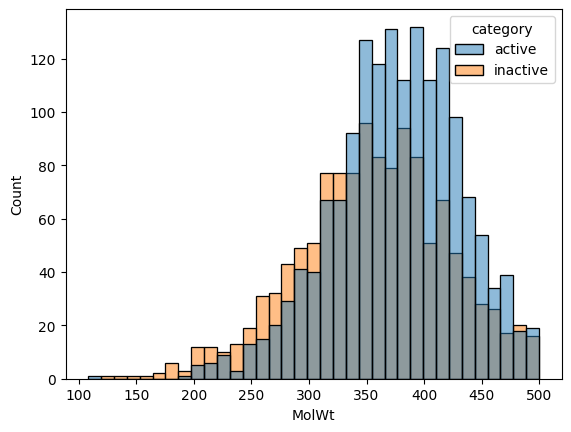

In [57]:
sns.histplot(
    data=combined_df,
    x="MolWt",
    hue="category",
    # ax=axes[0]
    # log_scale=True,
)

<Axes: xlabel='category', ylabel='NumHDonors'>

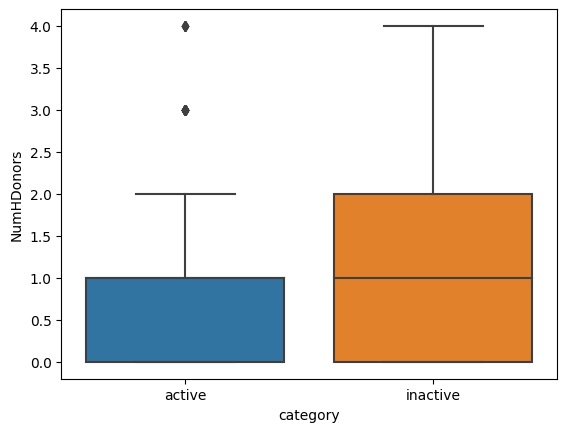

In [58]:
sns.boxplot(
    data=combined_df,
    y="NumHDonors",
    x="category",
    # ax=axes[1]
)